In [1]:
import os
import glob
import numpy as np
import pandas as pd
import qiime2 as q2
import matplotlib
import glob
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.ticker import MaxNLocator
from qiime2.plugins.diversity.actions import beta, pcoa
from skbio import DistanceMatrix, OrdinationResults
from skbio.stats.composition import closure
from biom import Table, load_table
from biom.util import biom_open
from gemelli.rpca import rpca, joint_rpca, feature_correlation_table, rpca_table_processing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr, ttest_ind, mannwhitneyu

np.seterr(all="ignore")
%matplotlib inline

In [2]:
tables = {omics_.split('/')[-1].split('.')[0]:rpca_table_processing(load_table(omics_),
                                                                    min_sample_count=0,
                                                                    min_feature_count=0,
                                                                    min_feature_frequency=0)
          for omics_ in glob.glob('../../data/case-studies/uc-severity-multiomics/Cohort_two/*.biom')}

metadata = pd.read_csv('../../data/case-studies/uc-severity-multiomics/Cohort_two/metadata_cohort_two_revised.txt', sep='\t', index_col=0)
tables

{'metaproteomics_cohort_two_matched': 108080 x 174 <class 'biom.table.Table'> with 5091405 nonzero entries (27% dense),
 'metagenomics_cohort_two_matched': 3499 x 174 <class 'biom.table.Table'> with 163422 nonzero entries (26% dense),
 'metabolomics_cohort_two_matched': 1928 x 174 <class 'biom.table.Table'> with 58524 nonzero entries (17% dense)}

In [3]:
# make table/metadata pair for each dataset of all samples in the data
tables_metdata_unshared = {}
for omics_, table_ in tables.items():
    print(omics_)
    metadata_omic = metadata.copy()
    table_omic = table_.copy()
    shared_samps = set(table_omic.ids()) & set(metadata.index)
    table_omic = table_omic.filter(shared_samps)
    table_omic = rpca_table_processing(table_omic, min_sample_count=0,
                                       min_feature_count=0,
                                       min_feature_frequency=0)
    metadata_omic = metadata_omic.reindex(shared_samps)
    table_omic_df = pd.DataFrame(table_omic.matrix_data.toarray(),
                                 table_omic.ids('observation'),
                                 table_omic.ids())
    tables_metdata_unshared[omics_] = [table_omic, table_omic_df, metadata_omic]
    
tables_metdata_unshared.keys()


metaproteomics_cohort_two_matched
metagenomics_cohort_two_matched
metabolomics_cohort_two_matched


dict_keys(['metaproteomics_cohort_two_matched', 'metagenomics_cohort_two_matched', 'metabolomics_cohort_two_matched'])

In [4]:
shared_samps = list(set.intersection(*[set(t_.ids()) for t_ in tables.values()]) & set(metadata.index))
metadata_shared = metadata.reindex(shared_samps)
metadata_shared['Diagnosis'] = [x.replace('UC','IBD').replace('CD','IBD')
                                       for x in metadata_shared.Diagnosis]
# re-close metaG/T data
metadata_shared = metadata_shared.reindex(shared_samps)
tables_shared = {t_k:t_.copy().filter(shared_samps) for t_k, t_ in tables.items()}
metadata_shared = pd.read_csv('../../data/case-studies/uc-severity-multiomics/Cohort_two/sample-metadata-plus-train-tests-case-study.csv', index_col=0)
metadata_shared.Diagnosis.value_counts()


IBD                157
Healthy_control     16
Name: Diagnosis, dtype: int64

In [5]:
ord_ = OrdinationResults.read('../../data/case-studies/uc-severity-multiomics/Cohort_two/case-study-joint-rpca-ord.txt')
ordindation_samples = pd.concat([ord_.samples, metadata_shared], axis=1, sort=False)
#ordindation_samples.head(10)

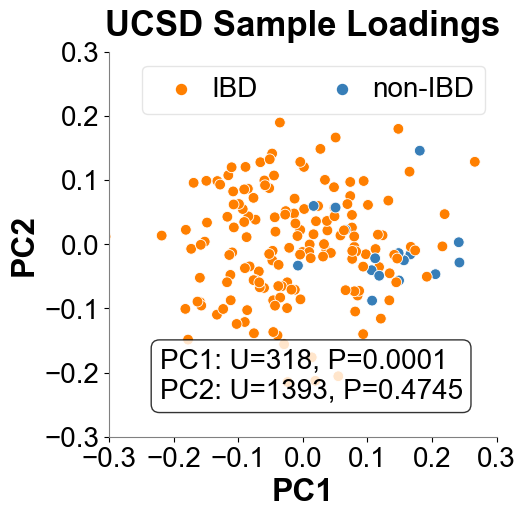

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

pal_ =  {'IBD':'#ff7f00', 'nonIBD':'#377eb8'}

ordindation_samples_plt = ordindation_samples.copy().rename({0:'PC1', 1:'PC2', 2:'PC3'}, axis=1)
ordindation_samples_plt['Diagnosis'] = ordindation_samples_plt['Diagnosis'].str.replace('Healthy_control','nonIBD')

sns.scatterplot(x='PC1', y='PC2', hue='Diagnosis', s=60,
                data=ordindation_samples_plt, ax=ax, palette=pal_)
                
txt_s = []
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
for pc_ in ['PC1','PC2']:
    f_, p_ = mannwhitneyu(ordindation_samples_plt[ordindation_samples_plt.Diagnosis == 'IBD'][pc_].values,
                          ordindation_samples_plt[ordindation_samples_plt.Diagnosis != 'IBD'][pc_].values)
    if p_ < 0.0001:
        p_ = 0.0001
    txt_s.append('%s: U=%d, P=%.4f' % (pc_, f_, p_))
ax.text(0.13, 0.1, '\n'.join(txt_s), fontsize=20, color='black', 
        fontname='Arial', transform=ax.transAxes, bbox=props)
    
ax.set_xlabel('PC1',
              color='black',
              weight='bold',
              fontname='Arial',
              fontsize=23)
ax.set_ylabel('PC2',
              color='black',
              weight='bold',
              fontname='Arial',
              fontsize=23)
ax.set_title('UCSD Sample Loadings',
              color='black',
              weight='bold',
              fontname='Arial',
              fontsize=25, y=1.02)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(20)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(20)
    
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], [l.replace('nonIBD','non-IBD') for l in labels], loc=2, 
                         bbox_to_anchor=(0.05, 1),
                         prop={'size':20, 'family':'Arial'},
                         fancybox=True, framealpha=.5, 
                         handletextpad=0.1, labelspacing=0.3,
                         ncol=2, markerscale=1.2)
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
    
ax.set_xlim(-.3, .3)
ax.set_ylim(-.3, .3)

plt.savefig('../../results/figure-4B.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/figure-4B.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [25]:
ranks_results = {}
min_f_use = 10
max_f_use = 100

ord_feat = ord_.features.copy()
for omics_, bt_tmp in tables_shared.items():

    min_f_use = 50
    max_f_use = 100

    tdf = pd.DataFrame(bt_tmp.matrix_data.toarray(), bt_tmp.ids('observation'), bt_tmp.ids())
    metadata_lr = metadata_shared.copy()
    feat_rank = ord_feat.loc[list(set(ord_feat.index) & set(tdf.index)), :].sort_values(0)
    for f_use in range(min_f_use, max_f_use):
        lr_ = np.log(tdf.loc[feat_rank.index[:f_use], :].sum(0)) \
              - np.log(tdf.loc[feat_rank.index[-f_use:], :].sum(0))
        lr_[~np.isfinite(lr_)] = np.nan
        if (f_use * 2) >= tdf.shape[0]:
            break
        if ((lr_.shape[0] - sum(np.isnan(lr_))) / lr_.shape[0]) > 0.99:
            break
        if omics_ == 'HMP2_proteomics_ecs':
            break
    tdf += tdf.values.mean()
    lr_ = np.log(tdf.loc[feat_rank.index[:f_use], :].sum(0)) \
              - np.log(tdf.loc[feat_rank.index[-f_use:], :].sum(0))
    metadata_lr = metadata_lr.loc[tdf.columns, :]
    metadata_lr[omics_ + 'log_ratio'] = lr_
    
    # remove multiple time points
    metadata_lr['Diagnosis'] = [x.replace('UC','IBD').replace('CD','IBD').replace('Healthy_control','nonIBD')
                                           for x in metadata_lr.Diagnosis]
    
    # save results used
    ranks_results[omics_] = [metadata_lr,
                             feat_rank.index[:f_use],
                             feat_rank.index[-f_use:]]

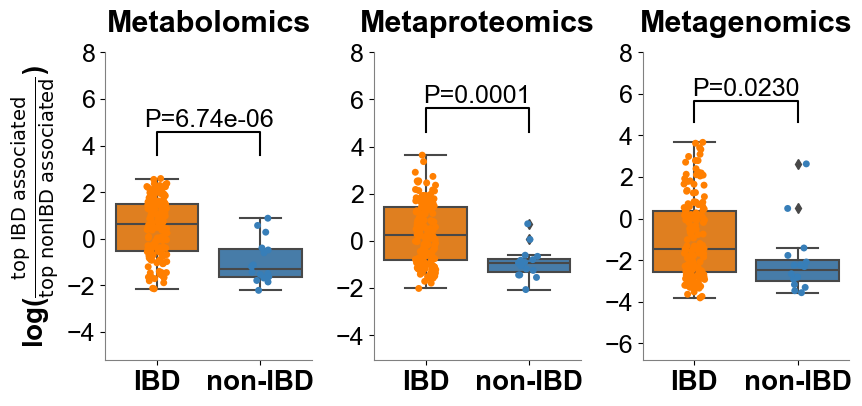

In [32]:
title_bls = {'metagenomics_cohort_two_matched':'Metagenomics',
             'metaproteomics_cohort_two_matched':'Metaproteomics',
             'metabolomics_cohort_two_matched':'Metabolomics'}

pal_ =  {'IBD':'#ff7f00', 'non-IBD':'#377eb8'}

fig, axn = plt.subplots(1, len(ranks_results), figsize=((16/5)*3, 4), 
                        sharex=True, sharey=False)

axn = axn.flatten()

for ax, omics_ in zip(axn, ['metabolomics_cohort_two_matched',
                            'metaproteomics_cohort_two_matched',
                            'metagenomics_cohort_two_matched']):
    
    metadata_lr, _, _ = ranks_results[omics_]
    metadata_lr['Diagnosis'] = [x.replace('nonIBD','non-IBD') for x in metadata_lr['Diagnosis']]
    sns.boxplot(y=omics_ + 'log_ratio', x='Diagnosis', data=metadata_lr, ax=ax, palette=pal_)
    sns.stripplot(y=omics_ + 'log_ratio', x='Diagnosis', data=metadata_lr, ax=ax, palette=pal_)
    ax.set_title(title_bls[omics_], color='black', weight='bold', 
                 fontsize=22, fontname='Arial', y=1.04)
    
    # statistical annotation
    a_ = metadata_lr[metadata_lr.Diagnosis == 'IBD'][omics_ + 'log_ratio'].dropna()
    b_ = metadata_lr[metadata_lr.Diagnosis != 'IBD'][omics_ + 'log_ratio'].dropna()
    U_, p_ = ttest_ind(b_, a_)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:4] + p_[p_.index('e'):]
    else:
        p_ = str(p_)[:6]
    x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = np.max([np.max(a_), np.max(b_)]) + 1, 1, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, "P=%s" %(p_), ha='center', fontname='Arial',
            va='bottom', color=col, fontsize=18)
    ax.set_ylim(np.min([np.min(a_), np.min(b_)]) - 3, 8)

for ax in axn:
    ax.set_xlabel('',
                  color='black',
                  weight='bold',
                  fontsize=16)
    ax.set_ylabel('',
                  color='black',
                  weight='bold',
                  fontsize=16)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(18)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(20)
        
axn[0].set_ylabel('log($\\frac{\\mathrm{top\,\,IBD\,\,associated}}{\\mathrm{top\,\,nonIBD\,\,associated}}$)',
                  fontname='Arial', color='black', weight='bold', fontsize=20)
        
plt.subplots_adjust(wspace=0.3)

plt.savefig('../../results/figure-4C.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/figure-4C.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [33]:
ord_cohort_two = OrdinationResults.read('../../data/case-studies/uc-severity-multiomics/Cohort_two/case-study-joint-rpca-ord.txt')
ordindation_samples_cohort_two = pd.concat([ord_.samples, metadata_shared], axis=1, sort=False)
metadata_shared_ihmp = pd.read_csv('../../data/simulations/ihmp/sample-metadata-plus-train-tests-case-study.csv', index_col=0)

ord_ihmp = OrdinationResults.read('../../data/case-studies/ihmp/joint-rpca/ord.txt')
ord_ihmp.samples.columns = ['PC1','PC2','PC3']
ordindation_samples_ihmp = pd.concat([ord_ihmp.samples, metadata_shared_ihmp], axis=1, sort=False).rename({0:'PC1', 1:'PC2', 2:'PC3'}, axis=1)
ordindation_samples_ihmp['diagnosis_binned'] = ordindation_samples_ihmp['diagnosis_binned'].replace('nonIBD', 'non-IBD')

# map genomoe level (1)
map_gcf = pd.read_csv('../../data/case-studies/uc-severity-multiomics/translate.txt', index_col=0)
map_gcf.index.name = int(map_gcf.index.name)
metag_index = set(ord_cohort_two.features.index) & set(map_gcf.index)
ord_cohort_two_metag = ord_cohort_two.features.copy()
ord_cohort_two_metag = ord_cohort_two_metag.reindex(metag_index)
map_gcf = map_gcf.reindex(metag_index)
ord_cohort_two_metag.index = map_gcf['gcf']
ord_cohort_two_metag = ord_cohort_two_metag.groupby(ord_cohort_two_metag.index).sum()
# map species (2)
ord_ihmp_metag = ord_ihmp.features.copy()
ord_ihmp_metag = ord_ihmp_metag.loc[[x for x in ord_ihmp.features.index if 't__GCF' in x], :]
ord_ihmp_metag.index = [x.split('|')[-1].replace('t__', '') for x in ord_ihmp_metag.index]
ord_ihmp_metag = ord_ihmp_metag.groupby(ord_ihmp_metag.index).sum()
# match
shared_lvl_ = list(set(ord_ihmp_metag.index) & set(ord_cohort_two_metag.index))
# match
ord_cohort_two_metag_matched = ord_cohort_two_metag.reindex(shared_lvl_)
ord_ihmp_metag_matched = ord_ihmp_metag.reindex(shared_lvl_)
ord_ihmp_metag_matched -= ord_ihmp_metag_matched.mean()
ord_cohort_two_metag_matched -= ord_cohort_two_metag_matched.mean()
# make taxonomy
gcf_ranks_tax = pd.read_csv('../../data/case-studies/uc-severity-multiomics/ranks.tsv', sep='\t',index_col=0)
map_gcf_dict = map_gcf.gcf.to_dict()
gcf_ranks_tax = gcf_ranks_tax.reindex(map_gcf_dict.keys())
gcf_ranks_tax.index = [map_gcf_dict[x] for x in gcf_ranks_tax.index]
for level_ in ['genus','species']:
    ord_cohort_two_metag_matched[level_] = [gcf_ranks_tax.loc[x, level_] for x in ord_cohort_two_metag_matched.index]
    ord_ihmp_metag_matched[level_] = [gcf_ranks_tax.loc[x, level_] for x in ord_ihmp_metag_matched.index]
print(len(shared_lvl_)/len(ord_ihmp_metag.index), len(shared_lvl_)/len(ord_cohort_two_metag.index), len(shared_lvl_))
all_joined_loadings = pd.DataFrame([ord_ihmp_metag_matched[0],  ord_cohort_two_metag_matched[0]], ['iHMP','UCSD']).T
map_gcf_rev = map_gcf.reset_index().set_index('gcf')[0].to_dict()
all_joined_loadings['wol'] = [map_gcf_rev[x] for x in all_joined_loadings.index]
all_joined_loadings.to_csv('../../data/case-studies/uc-severity-multiomics/Cohort_two/combined-loadings.csv')
#ord_cohort_two_metag *= -1
#all_joined_loadings.head(5)
    

0.5177664974619289 0.059509918319719954 102


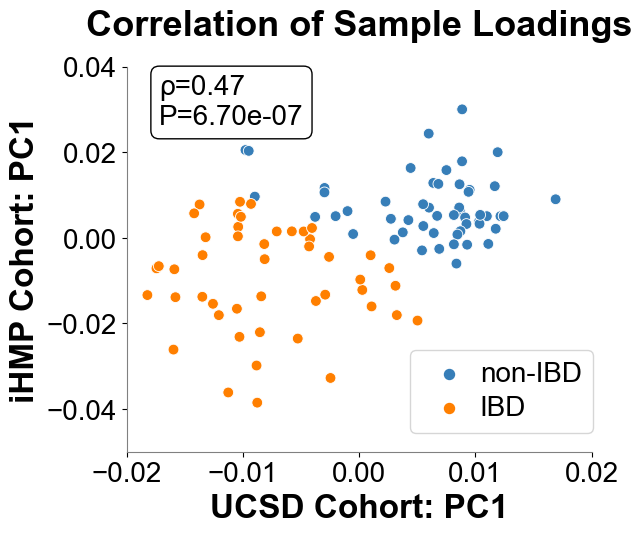

In [53]:
fig, ax = plt.subplots(figsize=(6, 5))

pal_ =  {'IBD':'#ff7f00', 'non-IBD':'#377eb8'}

all_joined_loadings_plt = all_joined_loadings.copy()
all_joined_loadings_plt['UCSD'] *= -1
all_joined_loadings_plt['grouping'] = 'non-IBD'
all_joined_loadings_plt.loc[all_joined_loadings_plt[['iHMP','UCSD']].mean(1) < 0, 'grouping'] = 'IBD'

sns.scatterplot(x='UCSD', y='iHMP', hue='grouping', data=all_joined_loadings_plt, palette=pal_, s=60)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(20)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(20)

ax.set_xlabel('UCSD Cohort: PC1',
              color='black',
              weight='bold',
              fontname='Arial',
              fontsize=24)
ax.set_ylabel('iHMP Cohort: PC1',
              color='black',
              weight='bold',
              fontname='Arial',
              fontsize=24)
ax.set_title('Correlation of Sample Loadings',
              color='black',
              weight='bold',
              fontname='Arial',
              fontsize=26, y=1.06)
ax.set_ylim(-0.05, 0.04)
ax.set_xlim(-0.02, 0.02)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

rho, p_ = spearmanr(all_joined_loadings_plt['UCSD'], all_joined_loadings_plt['iHMP'])
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:4] + p_[p_.index('e'):]
else:
    p_ = str(p_)[:6]
stat_ = "ρ=%.2f\nP=%s" % (rho, p_)
    
props = dict(boxstyle='round', facecolor='white', edgecolor='black')
ax.text(0.07, 0.85, stat_, transform=ax.transAxes, fontsize=20, bbox=props, 
        fontname='Arial', ha='left')
    
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels[:], loc=2, 
                         bbox_to_anchor=(0.58, 0.3),
                         prop={'size':20, 'family':'Arial'},
                         fancybox=True, framealpha=.8,
                         handletextpad=0.1, labelspacing=0.3,
                         ncol=1, markerscale=1.2)
legend.get_title().set_fontsize('20')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
    
plt.savefig('../../results/figure-4D.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/figure-4D.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()
